# Creating the Logistic Regression and Random Forest Model

In [2]:
import pandas as pd
import numpy as np
from numpy import mean

import datetime as dt

import matplotlib.pyplot as plt


#Sklearn
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.utils import resample, class_weight
from sklearn.metrics import precision_recall_curve, auc, make_scorer, average_precision_score, accuracy_score,\
recall_score, precision_score, f1_score, roc_curve, balanced_accuracy_score, roc_auc_score, classification_report,\
confusion_matrix, brier_score_loss
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer 
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

import seaborn as sns

In [3]:
#Global prameters
#Random state:
rs = 0

In [4]:
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 200

In [5]:
#Numeric features used in the model.
numModCol = ['acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'credit_hist_months',
            'dti', 'fico', 'inq_last_6mths', 'installment',  'mo_sin_rcnt_rev_tl_op',
            'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_actv_rev_tl', 'num_tl_op_past_12m', 
            'open_acc', 'percent_bc_gt_75', 'pub_rec', 'revol_bal', 'total_rev_hi_lim', 'int_rate']

In [6]:
#Categorical features used in the model.
catModCol = ['term',  'purpose', 'emp_length', 'home_ownership', 'verification_status', 'grade']

In [27]:
#Number of categorical features before one hot encoding.
len(catModCol)

6

In [28]:
#Number of numerical features.
len(numModCol)

21

In [7]:
%cd "C:\Users\Alex\Desktop\Ryerson - Data Science\Spring 2020\MRP Course\FromPandas"

C:\Users\Alex\Desktop\Ryerson - Data Science\Spring 2020\MRP Course\FromPandas


In [8]:
#Load the preprocessed pickled dataframe.
dfFinal = pd.read_pickle('dfFinal.pkl')

In [9]:
#Dataframe for modelling.
dfModel = dfFinal[numModCol+catModCol]

In [10]:
#Columns with missing values and percentage of instances containing them that need to be addressed.
dfMissing = pd.DataFrame((dfModel.isna().sum() / dfModel.shape[0] * 100)[dfModel.isna().sum() > 0])
dfMissing.index.name = 'Feature'
dfMissing.columns = ['Instance %']
dfMissing = dfMissing.round(3)
dfMissing = dfMissing.sort_values(by = ['Instance %'])
dfMissing

,Instance %
Feature,
dti,0.004
acc_open_past_24mths,4.250
mort_acc,4.250
mths_since_recent_bc,5.171
bc_open_to_buy,5.239
percent_bc_gt_75,5.275
mo_sin_rcnt_rev_tl_op,6.142
mo_sin_rcnt_tl,6.142
num_actv_rev_tl,6.142


## Drop unused categorical labels in categorical features.

In [11]:
for col in catModCol:
    dfFinal.loc[:, col] = dfFinal.loc[:,col].cat.remove_unused_categories()
    

## Establishing Training and Testing Instances

In [12]:
#Percentage of records by term and year.
yearTermQty = dfFinal.groupby(['issue_d_year', 'term'], observed=True).size()
termQty = dfFinal.groupby(['term'], observed=True).size()

In [13]:
yearTermQty.div(termQty, axis='index')

issue_d_year  term     
2007          36 months    0.000259
2008          36 months    0.001417
2009          36 months    0.004980
2010          36 months    0.008554
              60 months    0.019774
2011          36 months    0.014904
              60 months    0.055729
2012          36 months    0.046153
              60 months    0.077711
2013          36 months    0.106669
              60 months    0.271018
2014          36 months    0.172686
              60 months    0.575768
2015          36 months    0.300794
2016          36 months    0.343583
dtype: float64

In [14]:
#Checking the breakdown of 60 month loans by month in 2014 to establish cut-off.
group1 = dfFinal[(dfFinal.issue_d_year == '2014') & (dfFinal.term_numeric==60)].groupby(['issue_d_month']).size()
totalQty = dfFinal[(dfFinal.issue_d_year == '2014') & (dfFinal.term_numeric==60)].shape[0]
np.cumsum(group1.div(totalQty))

issue_d_month
1          0.056575
2          0.115791
3          0.182550
4          0.262025
5          0.344033
6          0.421661
7          0.549854
8          0.625565
9          0.669847
10         0.836970
11         0.953062
12         1.000000
Missing    1.000000
dtype: float64

In [18]:
#Locations of 36 months training and testing data.
train36 = ((dfFinal.term_numeric==36) & (dfFinal.issue_d <= dt.datetime(year=2015, month =12, day=31)))
test36 = ((dfFinal.term_numeric==36) & (dfFinal.issue_d > dt.datetime(year=2015, month =12, day=31)))
train36.sum(), test36.sum()

(617962, 323455)

In [19]:
#Locations of 60 months training and testing data.
train60 = ((dfFinal.term_numeric==60) & (dfFinal.issue_d <= dt.datetime(year = 2014, month = 6, day = 30)))
test60 = ((dfFinal.term_numeric==60) & (dfFinal.issue_d > dt.datetime(year = 2014, month = 6, day = 30)))
train60.sum(), test60.sum()

(84631, 42250)

In [17]:
#Count of each type of loan based on term.
count36 = (dfFinal.term_numeric==36).sum()
count60 = (dfFinal.term_numeric==60).sum()
count36, count60

(941417, 126881)

In [20]:
trainAll = (train36 | train60)
testAll = (test36 | test60)
trainAll.sum(), testAll.sum()

(702593, 365705)

In [21]:
#percentage breakdown of training and test sets based on loan term.
trainTest36 = pd.Series([train36.sum()/count36, test36.sum()/count36], name = '36 Months')
trainTest60 = pd.Series([train60.sum()/count60, test60.sum()/count60], name = '60 Months')
trainTestAll = pd.Series([trainAll.sum() / dfFinal.shape[0], testAll.sum()/dfFinal.shape[0]], name = 'All Data')
df = (pd.DataFrame([trainTest36, trainTest60, trainTestAll]).T*100).round(1)
df.index = ['Train %', 'Test %']
df.T

,Train %,Test %
36 Months,65.6,34.4
60 Months,66.7,33.3
All Data,65.8,34.2


In [22]:
#Get target labels for training and testing set.
trainLabels = pd.get_dummies(dfFinal.loan_status)['Charged Off'][trainAll]
testLabels = pd.get_dummies(dfFinal.loan_status)['Charged Off'][testAll]

## Missing Values Imputation

### Create Scalers for Numeric Features - Standardization (z-score Normalization) is used.

In [23]:
scaler = StandardScaler()

In [24]:
#Create scaler based on training set.
scaler = scaler.fit(dfFinal.loc[trainAll, numModCol])

In [25]:
#Apply scaler to entire dataset.
scaledArray = scaler.transform(dfFinal[numModCol])

In [26]:
#Convert array of scaled data into dataframe.
dfScaled = pd.DataFrame(scaledArray, columns=numModCol, index =dfFinal[numModCol].index )

### Create one-hot encoded indicator columns for all the categorical features.

In [29]:
oneEncoder = OneHotEncoder()

In [30]:
oneHotArray = oneEncoder.fit_transform(dfFinal[catModCol])

In [31]:
oneHotColumns = oneEncoder.get_feature_names(catModCol)

In [32]:
dfFinalOne = pd.concat([dfScaled, pd.DataFrame(oneHotArray.toarray(), columns=oneHotColumns, index = dfScaled.index)], axis = 1)

In [33]:
#Excludes original categorical columns.
dfFinalOneLimit = dfFinalOne[numModCol + oneHotColumns.tolist()]
dfFinalOneLimit.head()

,acc_open_past_24mths,annual_inc,avg_cur_bal,bc_open_to_buy,credit_hist_months,dti,fico,inq_last_6mths,installment,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_actv_rev_tl,num_tl_op_past_12m,open_acc,percent_bc_gt_75,pub_rec,revol_bal,total_rev_hi_lim,int_rate,term_36 months,term_60 months,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,emp_length_Missing,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,1.580095,-0.047358,2.309900,-0.498368,0.119843,-1.079649,0.637486,0.296605,-0.371608,0.340303,-0.568557,1.586125,-0.185791,-0.851168,2.335077,-0.248784,-1.385753,-0.333064,-0.660921,-0.699985,-0.281675,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.133706,-0.734901,-0.665976,-0.295089,1.518996,1.884512,0.637486,0.296605,-0.343091,-0.628604,-0.568557,-0.814465,-0.705763,0.093699,-0.598523,-0.248784,-0.446996,1.367555,-0.386778,-0.281345,0.077076,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-1.472931,-0.624495,-0.560560,-0.331473,-0.634388,0.199341,0.960813,-0.719712,0.567444,1.793664,2.237010,-0.814465,0.594166,-0.851168,-1.185243,-1.212674,0.494581,-0.333064,0.011673,-0.270879,0.424025,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.223194,0.102885,-0.649397,0.983254,1.431549,0.290006,1.769133,-0.719712,-0.719057,-0.507490,-0.352744,-0.814465,-0.640766,1.353522,0.574917,0.522328,-0.579493,-0.333064,-0.224812,0.320449,-1.733198,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.901645,-0.740144,-0.548986,NaN,-0.929522,1.078192,1.769133,-0.719712,-1.023848,0.037520,-0.352744,-0.814465,NaN,-1.166123,0.574917,-1.019896,NaN,-0.333064,-0.430548,-0.370306,-0.451609,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [34]:
#New dataframe shape after one hot encoding and excluding original categorical columns.
dfFinalOneLimit.shape

(1068298, 65)

### Missing Value Imputation

In [35]:
#Create imputer.
imp = IterativeImputer(estimator=LinearRegression(), verbose=2, min_value = dfFinalOneLimit.loc[trainAll].min(),
             max_value = dfFinalOneLimit.loc[trainAll].max(), skip_complete=True, tol = 0.001,
                      max_iter=15, random_state=rs)

In [269]:
#Fit the imputer on training scaled data.
imp = imp.fit(dfFinalOneLimit[trainAll])

In [270]:
imputedArray = imp.transform(dfFinalOneLimit)

In [ ]:
dfPostImpute = pd.DataFrame(imputedArray, columns=dfFinalOneLimit.columns, index = dfFinalOneLimit.index)

In [36]:
#Feature names that needed missing value imputation
missingColumns = dfMissing.index.values

In [161]:
#Used for google colab - saving the imputed files to be loaded in Google colab for training the NN model.
dfPostImpute[missingColumns].to_csv('missingImputs.csv', index = False)

In [37]:
#Loading previously imputed values to save time without needing to rerun the imputer every time.
dfImput = pd.read_csv('missingImputs.csv')

In [39]:
#Feature names in the loaded file with imputed values.
imputColumns = dfImput.columns

In [40]:
#Adding the loaded imputed values into the dataframe.
dfFinalOneLimit.loc[:, imputColumns] = dfImput.values

In [41]:
#The assigning the dataframe from previous call to a different name which was used in the coding below before I 
#started loading the imputed values.
dfPostImpute = dfFinalOneLimit

In [42]:
#Preview of the dataframe to be used in modelling.
dfPostImpute.head()

,acc_open_past_24mths,annual_inc,avg_cur_bal,bc_open_to_buy,credit_hist_months,dti,fico,inq_last_6mths,installment,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_actv_rev_tl,num_tl_op_past_12m,open_acc,percent_bc_gt_75,pub_rec,revol_bal,total_rev_hi_lim,int_rate,term_36 months,term_60 months,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,emp_length_Missing,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,1.580095,-0.047358,2.309900,-0.498368,0.119843,-1.079649,0.637486,0.296605,-0.371608,0.340303,-0.568557,1.586125,-0.185791,-0.851168,2.335077,-0.248784,-1.385753,-0.333064,-0.660921,-0.699985,-0.281675,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.133706,-0.734901,-0.665976,-0.295089,1.518996,1.884512,0.637486,0.296605,-0.343091,-0.628604,-0.568557,-0.814465,-0.705763,0.093699,-0.598523,-0.248784,-0.446996,1.367555,-0.386778,-0.281345,0.077076,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-1.472931,-0.624495,-0.560560,-0.331473,-0.634388,0.199341,0.960813,-0.719712,0.567444,1.793664,2.237010,-0.814465,0.594166,-0.851168,-1.185243,-1.212674,0.494581,-0.333064,0.011673,-0.270879,0.424025,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.223194,0.102885,-0.649397,0.983254,1.431549,0.290006,1.769133,-0.719712,-0.719057,-0.507490,-0.352744,-0.814465,-0.640766,1.353522,0.574917,0.522328,-0.579493,-0.333064,-0.224812,0.320449,-1.733198,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.901645,-0.740144,-0.548986,0.057983,-0.929522,1.078192,1.769133,-0.719712,-1.023848,0.037520,-0.352744,-0.814465,-0.033203,-1.166123,0.574917,-1.019896,-0.612549,-0.333064,-0.430548,-0.370306,-0.451609,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [43]:
#Shape of the dataframe to be used in modelling.
dfPostImpute.shape

(1068298, 65)

# Sample for performing cross validation grid search

In [44]:
dfTrain, dfTest, yTrain, yTest = train_test_split(dfPostImpute[trainAll], trainLabels, stratify = trainLabels, train_size =0.7, random_state=rs)

# Functions used in modelling.

In [46]:
def calcCost(y, y_pred, cost = (1,4), returnThreshold = False):
    #y_true must be a single column of binary labels for positive class.
    #y_prob must be single column of probabilities for positive class.
    
    thresholds = np.arange(0, 1, 0.001)
    result = y_pred.reshape(-1,1) >=  np.array(thresholds)
    
    #Convert boolean result array into binary array.
    resultBinary = result.astype('int')
    
    #Calculate loss from False Negatives
    lossFN = np.sum((y.values.reshape(-1,1) > resultBinary), axis=0)*cost[1]
    
    #Calculate loss from False Positive
    lossFP = np.sum((y.values.reshape(-1,1) < resultBinary), axis=0)*cost[0]
    
    totalLoss = lossFN + lossFP
    
    minInd = np.argmin(totalLoss)
    minThres = thresholds[minInd]
    minLoss = totalLoss[minInd]
    
    if returnThreshold:
        return minLoss, minThres
    else:
        return minLoss

In [47]:
def calcCostRev(y, y_pred, cost = (1,4), returnThreshold = False):
    #y_true must be a single column of binary labels for positive class.
    #y_prob must be single column of probabilities for positive class.
    
    thresholds = [0.5]
    result = y_pred.reshape(-1,1) >=  np.array(thresholds)
    
    #Convert boolean result array into binary array.
    resultBinary = result.astype('int')
    
    #Calculate loss from False Negatives
    lossFN = np.sum((y.values.reshape(-1,1) > resultBinary), axis=0)*cost[1]
    
    #Calculate loss from False Positive
    lossFP = np.sum((y.values.reshape(-1,1) < resultBinary), axis=0)*cost[0]
    
    totalLoss = lossFN + lossFP
    
    minInd = np.argmin(totalLoss)
    minThres = thresholds[minInd]
    minLoss = totalLoss[minInd]
    
    if returnThreshold:
        return minLoss, minThres
    else:
        return minLoss

In [48]:
def getLoss(y, y_hat, cost = (1,5)):
    #Calculate loss from False Negatives
    lossFN = np.sum(y > y_hat)*cost[1]
    
    #Calculate loss from False Positive
    lossFP = np.sum(y < y_hat)*cost[0]
    
    return lossFN+lossFP

In [49]:
def getFScore(y, y_prob):
    prec, recl, thres = precision_recall_curve(y, y_prob)
    fscore = (2 * prec * recl) / (prec + recl)
    maxInd = np.nanargmax(fscore)
    return fscore[maxInd]

In [50]:
def getFScoreThres(y, y_prob, threshold=True):
    prec, recl, thres = precision_recall_curve(y, y_prob)
    fscore = (2 * prec * recl) / (prec + recl)
    maxInd = np.nanargmax(fscore)
    if threshold:
        return fscore[maxInd], thres[maxInd]
    else:
        return fscore[maxInd]

In [51]:
highFScore = make_scorer(score_func=getFScore, greater_is_better=True, needs_proba=True)

In [52]:
def plot_roc(y_true, y_prob, plt, labelName):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    aucScore = np.round(roc_auc_score(y_true, y_prob),3)
    #fig, axs = plt.subplots(figsize=(3,3))
    plt.plot(fpr, tpr, label = labelName + '- AUC: '+str(aucScore))
    plt.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [53]:
def plot_pre_recl(y_true, y_prob, plt, labelName):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    plt.plot(recall, precision, label = labelName)
    plt.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Recall')
    plt.ylabel('Precision')

In [54]:
def getScores(y_true, y_pred, y_prob):
    scoresDict ={}
    scoresDict['Accuracy'] = accuracy_score(y_true, y_pred)
    scoresDict['Precision(+)'] = precision_score(y_true, y_pred)
    scoresDict['Recall(+)'] = recall_score(y_true, y_pred)
    scoresDict['AUC'] = roc_auc_score(y_true, y_prob)
    scoresDict['Error Cost'] = getLoss(y_true, y_pred)
    return pd.DataFrame(scoresDict, index=['Result'])
    

In [55]:
def to_labels(origProb, threshold):
    result = origProb >= threshold
    return result.astype('int')

In [56]:
def fScoreThres(y, y_prob):
    prec, recl, thres = precision_recall_curve(y, y_prob)
    fscore = (2 * prec * recl) / (prec + recl)
    maxInd = np.argmax(fscore)
    return fscore[maxInd], thres[maxInd]

In [57]:
def aucPreRec(y, y_prob):
    prec, recl, thres = precision_recall_curve(y, y_prob)
    aucScore = auc(prec, recl)
    return aucScore

In [58]:
def plotGridScores(gridObj):
    allResults = {}
    for score in gridObj.scorer_.keys():
        allResults[score] = gridObj.cv_results_['mean_test_'+score].tolist()
    pd.DataFrame.from_dict(allResults).plot()

# Scoring functions used in the gridsearches.

In [59]:
scoringDict2 = {'accuracy': make_scorer(accuracy_score), 
                'balanced_accuracy': make_scorer(balanced_accuracy_score),
               'f1': make_scorer(f1_score),
              'average_precision': make_scorer(average_precision_score, needs_proba=True), 
               'roc_auc': make_scorer(roc_auc_score, needs_proba=True), 
               'loan_loss': make_scorer(score_func=calcCostRev, greater_is_better=False, needs_proba=True, cost = (1,3.7), returnThreshold = False),
               'loan_loss2': make_scorer(score_func=calcCost, greater_is_better=False, needs_proba=True, cost = (1,2), returnThreshold = False),
               'loan_loss3': make_scorer(score_func=calcCost, greater_is_better=False, needs_proba=True, cost = (1,3), returnThreshold = False),
               'loan_loss4': make_scorer(score_func=calcCost, greater_is_better=False, needs_proba=True, cost = (1,4), returnThreshold = False),
               'loan_loss5': make_scorer(score_func=calcCost, greater_is_better=False, needs_proba=True, cost = (1,5), returnThreshold = False),
               'neg_brier_score': make_scorer(brier_score_loss, needs_proba=True)}

# Cross Validation object used across all modelling.

In [60]:
kFold = StratifiedKFold(n_splits=3, shuffle=True, random_state=rs)

# SGD Logistic Regression

## LR: Alpha, Penalty, and Learning Rate

In [61]:
#LR model.
sgdLearner1 = SGDClassifier(loss='log', penalty='l1', n_jobs=-1, random_state=rs, learning_rate='constant', 
                            early_stopping=True,
                            n_iter_no_change=20, eta0 = 0.001, alpha=0.00001)

In [62]:
#Values for alpha parameter
alpha = [10**i for i in range(-7,0)]
alpha

[1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]

In [63]:
#Setup pipeline.
steps = [('under', RandomUnderSampler(random_state=rs)),('model', sgdLearner1)]
pipeline = Pipeline(steps=steps)

In [64]:
#Learning rate parameters
learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive']

In [66]:
#Penalty parameters
penalty = ['l1', 'l2', 'elasticnet']

In [67]:
#Parameter grid.
pram_grid = [{'model__alpha': alpha, 'model__learning_rate': learning_rate,
              'model__penalty': penalty,
             'under': [None,
                        RandomUnderSampler(sampling_strategy=0.2, random_state=rs),
                        RandomUnderSampler(sampling_strategy=0.6, random_state=rs),
                        RandomUnderSampler(sampling_strategy=1.0, random_state=rs)]}]

In [1112]:
#Gridsearch
gridResultsLR2 = GridSearchCV(pipeline, param_grid=pram_grid, scoring=scoringDict2, cv = kFold, verbose=2, 
                            refit='roc_auc', n_jobs=-1)

In [1415]:
#Fitting the models based on the gridsearch
gridResultsLR2.fit(dfPostImpute[trainAll], trainLabels)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  6.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('under',
                                        RandomUnderSampler(random_state=0,
                                                           sampling_strategy=0.4)),
                                       ('model',
                                        SGDClassifier(alpha=1e-05,
                                                      early_stopping=True,
                                                      eta0=0.001,
                                                      learning_rate='constant',
                                                      loss='log', n_jobs=-1,
                                                      penalty='l1',
                                                      random_state=0))]),
             n_jobs=-1,
             param_grid=[{'model__alpha': [1e...
                      'loan_loss3': make_scorer(calcCost, greater_is_better=False, needs

In [1416]:
#Assigning the results
results_Grid_LR1_AUC_Orig = gridResultsLR2.cv_results_

In [1120]:
#Full results
results_Grid_LR1_AUC

{'mean_fit_time': array([ 9.79674586, 11.04724288,  5.47792665,  4.04433465,  7.15105669,
         8.82697058,  4.43303482,  3.57833783,  8.11972109, 10.15810919,
         5.19350402,  4.06870786,  9.06362271, 10.23627957,  5.49236314,
         4.15246216,  7.05695073,  8.17616534,  4.46994646,  3.66510955,
         9.60930371, 10.17026178,  5.12731425,  4.07798656,  7.62460343,
         9.86577566,  5.02318565,  3.95858558,  6.28738268,  8.63107038,
         4.79121081,  3.72911819,  8.0638752 ,  9.75060383,  4.95591187,
         3.94666918, 27.67504247, 27.61723328, 12.84219265, 10.00343362,
        20.78279265, 21.54239726,  9.96506182,  7.67849636, 30.24208244,
        30.80185056, 14.62287132, 10.41331577,  7.43676829,  9.43085265,
         4.72904785,  3.79046782,  6.10653067,  8.13226048,  4.28875597,
         3.42096861,  7.74838869,  9.62516713,  4.87963438,  3.97041043,
         9.42461141,  9.89089012,  5.04108787,  4.50844256,  6.04243882,
         8.21032159,  4.42383154, 

In [1153]:
#Best parameters based on AUC:
ind = np.argmin(results_Grid_LR1_AUC['rank_test_roc_auc'])
print('Parameters:', results_Grid_LR1_AUC['params'][ind])
print('ROC-AUC:', results_Grid_LR1_AUC['mean_test_roc_auc'][ind])
print('F1:', results_Grid_LR1_AUC['mean_test_f1'][ind])
#print('Average Precision:', results_Grid_LR1_AUC['mean_test_average_precision'][ind])
print('Accuracy:', results_Grid_LR1_AUC['mean_test_accuracy'][ind])
print('Balanced Accuracy:', results_Grid_LR1_AUC['mean_test_balanced_accuracy'][ind])
#print('Brier Score:', results_Grid_LR1_AUC['mean_test_neg_brier_score'][ind])
print('Loan Loss:', results_Grid_LR1_AUC['mean_test_loan_loss'][ind])

Parameters: {'model__alpha': 1e-07, 'model__learning_rate': 'adaptive', 'model__penalty': 'l2', 'under': None}
ROC-AUC: 0.692287233989569
F1: 0.010763617553287516
Accuracy: 0.8466936050409449
Balanced Accuracy: 0.5021495121015661
Loan Loss: -132231.0


In [1154]:
#Best parameters based on loan loss:
ind = np.argmin(results_Grid_LR1_AUC['rank_test_loan_loss'])
print('Parameters:', results_Grid_LR1_AUC['params'][ind])
print('ROC-AUC:', results_Grid_LR1_AUC['mean_test_roc_auc'][ind])
print('F1:', results_Grid_LR1_AUC['mean_test_f1'][ind])
#print('Average Precision:', results_Grid_LR1_AUC['mean_test_average_precision'][ind])
print('Accuracy:', results_Grid_LR1_AUC['mean_test_accuracy'][ind])
print('Balanced Accuracy:', results_Grid_LR1_AUC['mean_test_balanced_accuracy'][ind])
#print('Brier Score:', results_Grid_LR1_AUC['mean_test_neg_brier_score'][ind])
print('Loan Loss:', results_Grid_LR1_AUC['mean_test_loan_loss'][ind])

Parameters: {'model__alpha': 1e-07, 'model__learning_rate': 'adaptive', 'model__penalty': 'l2', 'under': RandomUnderSampler(random_state=0, sampling_strategy=0.6)}
ROC-AUC: 0.6920828911182128
F1: 0.32616400566065984
Accuracy: 0.7729040862324874
Balanced Accuracy: 0.6033114742725855
Loan Loss: -115286.23333333334


## LR: Undersampling and class_weight

In [1166]:
#Setup learner.
sgdLearner2 = SGDClassifier(loss='log', penalty='l2', n_jobs=-1, random_state=rs, learning_rate='adaptive', 
                            early_stopping=True, n_iter_no_change=20, eta0 = 0.001, alpha=0.0000001)

In [1168]:
#Setup pipeline.
steps = [('under', RandomUnderSampler()), ('model', sgdLearner2)]
pipeline = Pipeline(steps=steps)

In [1174]:
#Parameter values for gridsearch
param_grid = [{'under': [None, 
                         RandomUnderSampler(sampling_strategy=0.6, random_state=rs),
                         RandomUnderSampler(sampling_strategy=0.3, random_state=rs),
                         RandomUnderSampler(sampling_strategy=0.4, random_state=rs),
                         RandomUnderSampler(sampling_strategy=0.5, random_state=rs),
                         RandomUnderSampler(sampling_strategy=0.7, random_state=rs),
                         RandomUnderSampler(sampling_strategy=0.8, random_state=rs),
                         RandomUnderSampler(sampling_strategy=0.9, random_state=rs)]},
              {'under': [None],
               'model__class_weight': [None, 'balanced']}]

In [1175]:
param_grid

[{'under': [None,
   RandomUnderSampler(random_state=0, sampling_strategy=0.6),
   RandomUnderSampler(random_state=0, sampling_strategy=0.3),
   RandomUnderSampler(random_state=0, sampling_strategy=0.4),
   RandomUnderSampler(random_state=0, sampling_strategy=0.5),
   RandomUnderSampler(random_state=0, sampling_strategy=0.7),
   RandomUnderSampler(random_state=0, sampling_strategy=0.8),
   RandomUnderSampler(random_state=0, sampling_strategy=0.9)]},
 {'under': [None], 'model__class_weight': [None, 'balanced']}]

In [1176]:
#Gridsearch object.
gridLR3 = GridSearchCV(pipeline, param_grid=param_grid, scoring=scoringDict2, cv = kFold, verbose=3,
                                        refit='roc_auc', n_jobs=-1)

In [1177]:
#Evaluating the gridsearch.
gridLR3.fit(dfPostImpute[trainAll], trainLabels)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('under', RandomUnderSampler()),
                                       ('model',
                                        SGDClassifier(alpha=1e-07,
                                                      early_stopping=True,
                                                      eta0=0.001,
                                                      learning_rate='adaptive',
                                                      loss='log',
                                                      n_iter_no_change=20,
                                                      n_jobs=-1,
                                                      random_state=0))]),
             n_jobs=-1,
             param_grid=[{'under': [None,
                                    RandomUnderSampler(random_state=0...
                      'average_precision': make_scorer(average_precision_score, needs_proba=True)

In [1178]:
#Assigning gridsearch results
results_Grid2_LR_AUC = gridLR3.cv_results_

In [1179]:
#Best parameters based on AUC:
ind = np.argmin(results_Grid2_LR_AUC['rank_test_roc_auc'])
print('Parameters:', results_Grid2_LR_AUC['params'][ind])
print('ROC-AUC:', results_Grid2_LR_AUC['mean_test_roc_auc'][ind])
print('F1:', results_Grid2_LR_AUC['mean_test_f1'][ind])
print('Accuracy:', results_Grid2_LR_AUC['mean_test_accuracy'][ind])
print('Balanced Accuracy:', results_Grid2_LR_AUC['mean_test_balanced_accuracy'][ind])
print('Loan Loss:', results_Grid2_LR_AUC['mean_test_loan_loss'][ind])

Parameters: {'under': None}
ROC-AUC: 0.6923093033781349
F1: 0.010925930647811893
Accuracy: 0.8466779487668094
Balanced Accuracy: 0.502174520083923
Loan Loss: -132226.56666666668


In [1180]:
#Best parameters based on loan loss:
ind = np.argmin(results_Grid2_LR_AUC['rank_test_loan_loss'])
print('Parameters:', results_Grid2_LR_AUC['params'][ind])
print('ROC-AUC:', results_Grid2_LR_AUC['mean_test_roc_auc'][ind])
print('F1:', results_Grid2_LR_AUC['mean_test_f1'][ind])
print('Accuracy:', results_Grid2_LR_AUC['mean_test_accuracy'][ind])
print('Balanced Accuracy:', results_Grid2_LR_AUC['mean_test_balanced_accuracy'][ind])
print('Loan Loss:', results_Grid2_LR_AUC['mean_test_loan_loss'][ind])

Parameters: {'under': RandomUnderSampler(random_state=0, sampling_strategy=0.7)}
ROC-AUC: 0.6920429621421148
F1: 0.34547757741940766
Accuracy: 0.7347596696015607
Balanced Accuracy: 0.6210052795740183
Loan Loss: -114709.26666666666


## LR: eta0

In [1420]:
#Setup learner.
sgdLearner2 = SGDClassifier(loss='log', penalty='l2', n_jobs=-1, random_state=rs, learning_rate='adaptive', 
                            early_stopping=True, n_iter_no_change=20, eta0 = 0.001, alpha=0.0000001)

In [1422]:
#Setup pipeline.
steps = [('under', RandomUnderSampler(sampling_strategy=0.7, random_state=rs)), ('model', sgdLearner2)]
pipeline = Pipeline(steps=steps)

In [1423]:
#eta0 values for gridsearch
eta0 = [10**i for i in range(-5,0)]

In [1277]:
eta0

[1e-05, 0.0001, 0.001, 0.01, 0.1]

In [1425]:
#Parameters for gridsearch
param_grid = [{'model__eta0': eta0}]

In [1426]:
param_grid

[{'model__eta0': [1e-05, 0.0001, 0.001, 0.01, 0.1]}]

In [1427]:
#Gridsearch object
gridLR3 = GridSearchCV(pipeline, param_grid=param_grid, scoring=scoringDict2, cv = kFold, verbose=3,
                                        refit='loan_loss', n_jobs=3)

In [1428]:
#Evaluating the gridsearch.
gridLR3.fit(dfPostImpute[trainAll], trainLabels)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:  3.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('under',
                                        RandomUnderSampler(random_state=0,
                                                           sampling_strategy=0.7)),
                                       ('model',
                                        SGDClassifier(alpha=1e-07,
                                                      early_stopping=True,
                                                      eta0=0.001,
                                                      learning_rate='adaptive',
                                                      loss='log',
                                                      n_iter_no_change=20,
                                                      n_jobs=-1,
                                                      random_state=0))]),
             n_jobs=3,
             param_grid=[{'model__eta0...
                      'loan_loss3':

In [1429]:
#Assigning results of the gridsearch.
results_Grid3_LR = gridLR3.cv_results_

In [1284]:
#Best parameters based on loan loss:
ind = np.argmin(results_Grid3_LR['rank_test_loan_loss'])
print('Parameters:', results_Grid3_LR['params'][ind])
print('ROC-AUC:', results_Grid3_LR['mean_test_roc_auc'][ind])
print('F1:', results_Grid3_LR['mean_test_f1'][ind])
print('Accuracy:', results_Grid3_LR['mean_test_accuracy'][ind])
print('Balanced Accuracy:', results_Grid3_LR['mean_test_balanced_accuracy'][ind])
print('Loan Loss:', results_Grid3_LR['mean_test_loan_loss'][ind])

Parameters: {'model__eta0': 0.1, 'model__max_iter': 100}
ROC-AUC: 0.6919465578589947
F1: 0.34476554755730904
Accuracy: 0.7381727391802123
Balanced Accuracy: 0.6200329441390753
Loan Loss: -114616.43333333335


In [1430]:
#Best parameters based on loan loss:
ind = np.argmin(results_Grid3_LR['rank_test_loan_loss'])
print('Parameters:', results_Grid3_LR['params'][ind])
print('ROC-AUC:', results_Grid3_LR['mean_test_roc_auc'][ind])
print('F1:', results_Grid3_LR['mean_test_f1'][ind])
print('Accuracy:', results_Grid3_LR['mean_test_accuracy'][ind])
print('Balanced Accuracy:', results_Grid3_LR['mean_test_balanced_accuracy'][ind])
print('Loan Loss:', results_Grid3_LR['mean_test_loan_loss'][ind])

Parameters: {'model__eta0': 0.1}
ROC-AUC: 0.6920234345868245
F1: 0.34548723923662344
Accuracy: 0.7347440132970385
Balanced Accuracy: 0.621015064432354
Loan Loss: -114708.43333333333


# FINAL: Logistic Regression Model

In [1440]:
#Setup learner.
sgdLogLearnerFinal = SGDClassifier(loss='log', penalty='l2', n_jobs=-1, random_state=rs, learning_rate='adaptive', 
                            early_stopping=True, n_iter_no_change=20, eta0 = 0.1, alpha=0.0000001, max_iter=1000)

In [1441]:
#Setup pipeline.
stepsLog = [('under', RandomUnderSampler(sampling_strategy=0.7, random_state=rs)), ('model', sgdLogLearnerFinal)]
pipelineLog = Pipeline(steps=stepsLog)

In [1442]:
#Model using pipeline.
pipelineLog.fit(dfPostImpute[trainAll], trainLabels)

Pipeline(steps=[('under',
                 RandomUnderSampler(random_state=0, sampling_strategy=0.7)),
                ('model',
                 SGDClassifier(alpha=1e-07, early_stopping=True, eta0=0.1,
                               learning_rate='adaptive', loss='log',
                               n_iter_no_change=20, n_jobs=-1,
                               random_state=0))])

In [1443]:
#Model
model_LR_Final = pipelineLog[1]

In [1444]:
#Coefficients of the model
model_LR_Final.coef_[0]

array([ 0.15321994, -0.10608688, -0.06394024, -0.00440388, -0.01858805,
        0.12388084, -0.1041584 ,  0.05336857,  0.10666981,  0.02358108,
       -0.03570565, -0.06334034, -0.06419003,  0.06665411,  0.02254944,
       -0.07983814,  0.02864404, -0.00344223,  0.02030868, -0.10533221,
        0.15146144, -0.20662868,  0.27996585, -0.1527876 , -0.21482195,
       -0.12353167,  0.77843557, -0.05847721, -0.11239988, -0.13101134,
        0.03851715, -0.01313884, -0.05991154,  0.21078365,  0.42938306,
       -0.10665671, -0.41104552, -0.02044424, -0.03827678, -0.06128765,
       -0.06166908, -0.06603733, -0.02148198, -0.04000481, -0.04038828,
       -0.01464797, -0.0043164 ,  0.0070882 ,  0.4348035 ,  0.        ,
       -0.31792537,  0.7362217 ,  0.0321388 , -0.23766325, -0.13943471,
       -0.01546291,  0.08000521,  0.00879487, -0.52395059, -0.18281953,
        0.04831497,  0.14621056,  0.20448175,  0.18150174,  0.19959828])

In [1445]:
#Obtain predictions
y_prob = pipelineLog.predict_proba(dfPostImpute[testAll])
y_hat = pipelineLog.predict(dfPostImpute[testAll])

In [1446]:
#Confusion matrix
confusion_matrix(y_true=testLabels, y_pred=y_hat, labels=[0, 1])

array([[236579,  66464],
       [ 33070,  29592]], dtype=int64)

In [1447]:
#Scores for the model
getScores(testLabels, y_hat, y_prob[:,1])

,Accuracy,Precision(+),Recall(+),AUC,Error Cost
Result,0.72783,0.30807,0.472248,0.696921,231814


In [1450]:
#Put the predictions into a dictionary object.
resultsLR = {'id': dfFinal[testAll].id.values, 'true_class': testLabels, 'predict_class_LR': y_hat, 
                 'prob_LR':y_prob[:,1]}

In [1451]:
#Create dataframe from dictionary results object.
df_Results_LR = pd.DataFrame(resultsLR)

In [1452]:
#Preview of dataframe with the results.
df_Results_LR.head()

,id,true_class,predict_class_LR,prob_LR
0,73713571,0,0,0.377908
1,75051478,0,0,0.450985
2,75092979,0,0,0.360520
3,75123593,0,0,0.223180
5,75358919,0,0,0.393617


In [1453]:
#Save the results to a file.
df_Results_LR.to_csv('results_LR3.csv', index=False)

# RF Grid Search #1: Undersampling, and max_samples

In [1220]:
#Random forest learner to be used in first gridsearch.
rfLearn1 = RandomForestClassifier(n_estimators=50, max_features='auto', n_jobs=-1, random_state=rs, 
                             verbose=3)

In [1221]:
#Setup pipeline.
steps = [('under', RandomUnderSampler()), ('model', rfLearn1)]
pipeline = Pipeline(steps=steps)

In [1222]:
#Parameters to in gridsearch.
param_grid = [{'under': [None,
                        RandomUnderSampler(random_state=rs, sampling_strategy=0.2),
                        RandomUnderSampler(random_state=rs, sampling_strategy=0.6),
                        RandomUnderSampler(random_state=rs, sampling_strategy=1.0)],
               'model__max_samples': [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, None]},
              
              {'under': [None],
               'model__class_weight': ['balanced', None], 
              'model__max_samples': [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, None]}]

In [1223]:
#Gridsearch object
gridRF1 = GridSearchCV(pipeline, param_grid=param_grid, scoring=scoringDict2, cv = kFold, verbose=3,
                                        refit='roc_auc', n_jobs=-1)

In [1224]:
#Cross validate using the gridsearch object.
gridRF1.fit(dfPostImpute[trainAll], trainLabels)

Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed: 66.6min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 50building tree 2 of 50building tree 3 of 50building tree 4 of 50



building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   12.9s



building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('under', RandomUnderSampler()),
                                       ('model',
                                        RandomForestClassifier(n_estimators=50,
                                                               n_jobs=-1,
                                                               random_state=0,
                                                               verbose=3))]),
             n_jobs=-1,
             param_grid=[{'model__max_samples': [0.05, 0.1, 0.2, 0.4, 0.6, 0.8,
                                                 None],
                          'under': [None,
                                    RandomUnderSampler(random_state=0,
                                                       sampling_s...
                      'average_precision': make_scorer(average_precision_score, needs_proba=True),
                      'balanced_accuracy': make_scor

In [1225]:
#Assign the results of the gridsearch
results_Grid1_RF = gridRF1.cv_results_

In [1228]:
#Best parameters based on roc_auc:
ind = np.argmin(results_Grid1_RF['rank_test_roc_auc'])
print('Parameters:', results_Grid1_RF['params'][ind])
print('ROC-AUC:', results_Grid1_RF['mean_test_roc_auc'][ind])
print('F1:', results_Grid1_RF['mean_test_f1'][ind])
print('Accuracy:', results_Grid1_RF['mean_test_accuracy'][ind])
print('Balanced Accuracy:', results_Grid1_RF['mean_test_balanced_accuracy'][ind])
print('Loan Loss:', results_Grid1_RF['mean_test_loan_loss'][ind])

Parameters: {'model__max_samples': 0.6, 'under': RandomUnderSampler(random_state=0, sampling_strategy=0.6)}
ROC-AUC: 0.6797368138908159
F1: 0.31358887884145753
Accuracy: 0.767412995867983
Balanced Accuracy: 0.5951750965779591
Loan Loss: -117247.46666666667


In [1229]:
#Best parameters based on loan loss:
ind = np.argmin(results_Grid1_RF['rank_test_loan_loss'])
print('Parameters:', results_Grid1_RF['params'][ind])
print('ROC-AUC:', results_Grid1_RF['mean_test_roc_auc'][ind])
print('F1:', results_Grid1_RF['mean_test_f1'][ind])
print('Accuracy:', results_Grid1_RF['mean_test_accuracy'][ind])
print('Balanced Accuracy:', results_Grid1_RF['mean_test_balanced_accuracy'][ind])
print('Loan Loss:', results_Grid1_RF['mean_test_loan_loss'][ind])

Parameters: {'model__max_samples': 0.6, 'under': RandomUnderSampler(random_state=0, sampling_strategy=0.6)}
ROC-AUC: 0.6797368138908159
F1: 0.31358887884145753
Accuracy: 0.767412995867983
Balanced Accuracy: 0.5951750965779591
Loan Loss: -117247.46666666667


In [1230]:
#All results
results_Grid1_RF

{'mean_fit_time': array([ 21.6316282 ,  25.25661159,  12.75637404,   9.12195404,
         36.48321478,  38.64590001,  18.67038576,  14.04448549,
         80.54567607,  71.25994007,  30.87309361,  20.69643219,
        132.5734818 , 119.71157749,  48.87266763,  31.08212241,
        180.00739487, 163.59950662,  64.48137744,  42.7154301 ,
        223.34902891, 212.04337263,  82.12765145,  58.19690569,
        293.15650773, 266.17719618,  97.89947319,  60.58461833,
         26.03538116,  37.87727896,  72.4190553 , 131.34054263,
        187.92892154, 236.84856621, 267.27989697,  30.51621064,
         43.5537742 ,  77.73167928, 138.27381333, 187.58780217,
        240.37074272, 231.64949584]),
 'std_fit_time': array([ 0.40164966,  2.46533821,  2.10967126,  0.52945885,  1.32065555,
         3.3172217 ,  1.78665683,  0.84004002,  0.92958355, 10.04814206,
         2.28060911,  1.08449482,  0.82412844,  7.27585925,  3.42088033,
         0.76241183,  3.04395774,  7.02347749,  4.19947322,  1.1787932

# RF Grid Search #2: max_features and max_depth

In [1245]:
#Random Forest object for gridsearch.
rfLearn1 = RandomForestClassifier(n_estimators=50, max_features='auto', n_jobs=-1, random_state=rs, 
                             verbose=3, max_samples=0.6)

In [1237]:
#Setup pipeline.
steps4 = [('under', RandomUnderSampler(sampling_strategy=0.6, random_state=rs)), ('model', rfLearn1)]
pipeline4 = Pipeline(steps=steps4)

In [1238]:
#Parameters to test in gridsearch
param_grid4 = [{'model__max_features': [0.2, 0.3, 0.4, 0.5, 'auto'],
              'model__max_depth': [None, 1, 2, 5, 10, 15, 20],
               }]

In [1240]:
#Gridsearch object
gridRF4 = GridSearchCV(pipeline4, param_grid=param_grid4, scoring=scoringDict2, cv = kFold2, verbose=1,
                                        refit='roc_auc', n_jobs=-1)

In [1241]:
#Cross validate using the gridsearch object.
gridRF4.fit(dfPostImpute[trainAll], trainLabels)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 36.7min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 50building tree 2 of 50

building tree 3 of 50building tree 4 of 50

building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   27.5s


building tree 29 of 50
building tree 30 of 50
building tree 31 of 50building tree 32 of 50

building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   53.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('under',
                                        RandomUnderSampler(random_state=0,
                                                           sampling_strategy=0.6)),
                                       ('model',
                                        RandomForestClassifier(max_samples=0.6,
                                                               n_estimators=50,
                                                               n_jobs=-1,
                                                               random_state=0,
                                                               verbose=3))]),
             n_jobs=-1,
             param_grid=[{'model__max_depth': [None, 1, 2, 5, 10, 15, 20],
                          'model__max_featur...
                      'average_precision': make_scorer(average_precision_score, needs_proba=True),
                      'balanced

In [1242]:
#Assign the results of the gridsearch
results_Grid2_RF = gridRF4.cv_results_

In [1243]:
#Best parameters based on roc_auc:
ind = np.argmin(results_Grid2_RF['rank_test_roc_auc'])
print('Parameters:', results_Grid2_RF['params'][ind])
print('ROC-AUC:', results_Grid2_RF['mean_test_roc_auc'][ind])
print('F1:', results_Grid2_RF['mean_test_f1'][ind])
print('Accuracy:', results_Grid2_RF['mean_test_accuracy'][ind])
print('Balanced Accuracy:', results_Grid2_RF['mean_test_balanced_accuracy'][ind])
print('Loan Loss:', results_Grid2_RF['mean_test_loan_loss'][ind])

Parameters: {'model__max_depth': 10, 'model__max_features': 0.5}
ROC-AUC: 0.6913995756690011
F1: 0.32349636371560814
Accuracy: 0.7748653895945722
Balanced Accuracy: 0.6014515156657071
Loan Loss: -115540.59999999999


In [1244]:
#Best parameters based on loan_loss:
ind = np.argmin(results_Grid2_RF['rank_test_loan_loss'])
print('Parameters:', results_Grid2_RF['params'][ind])
print('ROC-AUC:', results_Grid2_RF['mean_test_roc_auc'][ind])
print('F1:', results_Grid2_RF['mean_test_f1'][ind])
print('Accuracy:', results_Grid2_RF['mean_test_accuracy'][ind])
print('Balanced Accuracy:', results_Grid2_RF['mean_test_balanced_accuracy'][ind])
print('Loan Loss:', results_Grid2_RF['mean_test_loan_loss'][ind])

Parameters: {'model__max_depth': 15, 'model__max_features': 0.5}
ROC-AUC: 0.6906392541130514
F1: 0.32798643327190424
Accuracy: 0.7687067750615687
Balanced Accuracy: 0.6047988491128883
Loan Loss: -115331.43333333333


# RF Grid Search #3: max_depth and Undersampling

In [1302]:
#Random Forest object for gridsearch
rfLearn1 = RandomForestClassifier(n_estimators=50, max_features=0.5, n_jobs=-1, random_state=rs, 
                             verbose=3, max_samples=0.6)

In [1303]:
#Setup pipeline.
steps5 = [('under', RandomUnderSampler(sampling_strategy=0.6, random_state=rs)), ('model', rfLearn1)]
pipeline5 = Pipeline(steps=steps5)

In [1304]:
#Parameters for gridsearch.
param_grid5 = [{'model__max_depth': [10, 15],
                'under': [RandomUnderSampler(random_state=rs, sampling_strategy=0.3),
                        RandomUnderSampler(random_state=rs, sampling_strategy=0.4),
                        RandomUnderSampler(random_state=rs, sampling_strategy=0.5),
                        RandomUnderSampler(random_state=rs, sampling_strategy=0.6),
                        RandomUnderSampler(random_state=rs, sampling_strategy=0.7),
                        RandomUnderSampler(random_state=rs, sampling_strategy=0.8),
                        RandomUnderSampler(random_state=rs, sampling_strategy=0.9)]}]

In [1305]:
#Create gridsearch object.
gridRF5 = GridSearchCV(pipeline5, param_grid=param_grid5, scoring=scoringDict2, cv = kFold2, verbose=1,
                                        refit='roc_auc', n_jobs=-1)

In [1306]:
#Cross validate using the gridsearch.
gridRF5.fit(dfPostImpute[trainAll], trainLabels)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed: 25.8min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 50building tree 2 of 50building tree 3 of 50

building tree 4 of 50

building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   38.1s


building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('under',
                                        RandomUnderSampler(random_state=0,
                                                           sampling_strategy=0.6)),
                                       ('model',
                                        RandomForestClassifier(max_features=0.5,
                                                               max_samples=0.6,
                                                               n_estimators=50,
                                                               n_jobs=-1,
                                                               random_state=0,
                                                               verbose=3))]),
             n_jobs=-1,
             param_grid=[{'model__max_depth': [10, 15],
                          'under': [Random...
                      'average_precision': make_scorer(average_precisi

In [1307]:
#Assign the results of the gridsearch.
results_Grid3_RF = gridRF5.cv_results_

In [1308]:
#Best parameters based on roc_auc:
ind = np.argmin(results_Grid3_RF['rank_test_roc_auc'])
print('Parameters:', results_Grid3_RF['params'][ind])
print('ROC-AUC:', results_Grid3_RF['mean_test_roc_auc'][ind])
print('F1:', results_Grid3_RF['mean_test_f1'][ind])
print('Accuracy:', results_Grid3_RF['mean_test_accuracy'][ind])
print('Balanced Accuracy:', results_Grid3_RF['mean_test_balanced_accuracy'][ind])
print('Loan Loss:', results_Grid3_RF['mean_test_loan_loss'][ind])

Parameters: {'model__max_depth': 10, 'under': RandomUnderSampler(random_state=0, sampling_strategy=0.3)}
ROC-AUC: 0.6916859372585149
F1: 0.06657678173288102
Accuracy: 0.8449358306779792
Balanced Accuracy: 0.5136707334185636
Loan Loss: -129672.66666666667


In [1309]:
#Best parameters based on loan_loss:
ind = np.argmin(results_Grid3_RF['rank_test_loan_loss'])
print('Parameters:', results_Grid3_RF['params'][ind])
print('ROC-AUC:', results_Grid3_RF['mean_test_roc_auc'][ind])
print('F1:', results_Grid3_RF['mean_test_f1'][ind])
print('Accuracy:', results_Grid3_RF['mean_test_accuracy'][ind])
print('Balanced Accuracy:', results_Grid3_RF['mean_test_balanced_accuracy'][ind])
print('Loan Loss:', results_Grid3_RF['mean_test_loan_loss'][ind])

Parameters: {'model__max_depth': 10, 'under': RandomUnderSampler(random_state=0, sampling_strategy=0.7)}
ROC-AUC: 0.6912330886391942
F1: 0.34485558008344447
Accuracy: 0.7316938811657594
Balanced Accuracy: 0.6208392206826635
Loan Loss: -115038.46666666667


## RF: Determine optimal forest size.

In [68]:
from matplotlib.legend_handler import HandlerLine2D

train_results_AUC = []
test_results_AUC = []

train_results_BalAcc = []
test_results_BalAcc = []

train_results_LoanLoss = []
test_results_LoanLoss = []

train_results_OvrAcc = []
test_results_OvrAcc = []

#balanced_accuracy_score

list_nb_trees = [3]*67

rf = RandomForestClassifier(n_estimators=0, max_features=0.5, n_jobs=3, random_state=rs, 
                             verbose=3, max_samples=0.6, max_depth = 10, warm_start=True)


for nb_trees in list_nb_trees:

    rf.n_estimators += nb_trees
    
    steps5 = [('under', RandomUnderSampler(sampling_strategy=0.7, random_state=rs)), ('model', rf)]
    pipeline5 = Pipeline(steps=steps5)
    pipeline5.fit(dfTrain, yTrain)
    
    trainProb = pipeline5.predict_proba(dfTrain)
    testProb = pipeline5.predict_proba(dfTest)
    
    #AUC metrics
    trainAUC = roc_auc_score(y_true=yTrain, y_score=trainProb[:,1])
    testAUC = roc_auc_score(y_true=yTest, y_score=testProb[:,1])
    train_results_AUC.append(trainAUC)
    test_results_AUC.append(testAUC)
    
    #Balanced accuracy metrics
    trainAcc = balanced_accuracy_score(y_true=yTrain, y_pred=np.argmax(trainProb, axis=1))
    testAcc = balanced_accuracy_score(y_true=yTest, y_pred=np.argmax(testProb, axis=1))
    train_results_BalAcc.append(trainAcc)
    test_results_BalAcc.append(testAcc)
    
    #Overall accuracy.
    trainAcc_Ovr = accuracy_score(y_true=yTrain, y_pred=np.argmax(trainProb, axis=1))
    testAcc_Ovr = accuracy_score(y_true=yTest, y_pred=np.argmax(testProb, axis=1))
    train_results_OvrAcc.append(trainAcc_Ovr)
    test_results_OvrAcc.append(testAcc_Ovr)
    
    #Loan loss metric
    loan_loss_train = calcCostRev(yTrain, trainProb[:,1], cost = (1,3.7), returnThreshold = False)
    loan_loss_test = calcCostRev(yTest, testProb[:,1], cost = (1,3.7), returnThreshold = False)
    train_results_LoanLoss.append(loan_loss_train)
    test_results_LoanLoss.append(loan_loss_test)



[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3
building tree 2 of 3
building tree 3 of 3


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3building tree 3 of 3




[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3
building tree 2 of 3
building tree 3 of 3


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3building tree 3 of 3




[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3
building tree 2 of 3
building tree 3 of 3


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3building tree 3 of 3




[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3building tree 3 of 3




[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  21 out of  21 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  21 out of  21 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3
building tree 2 of 3
building tree 3 of 3


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  24 out of  24 | elapsed:    1.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  24 out of  24 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3building tree 3 of 3




[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  27 out of  27 | elapsed:    1.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  27 out of  27 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3building tree 3 of 3




[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:    1.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3
building tree 2 of 3
building tree 3 of 3


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=3)]: Done  33 out of  33 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done  33 out of  33 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done  36 out of  36 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done  36 out of  36 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3
building tree 2 of 3building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  39 out of  39 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done  39 out of  39 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  42 out of  42 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done  42 out of  42 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3building tree 3 of 3




[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  48 out of  48 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done  48 out of  48 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3building tree 3 of 3




[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done  51 out of  51 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done  51 out of  51 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3
building tree 2 of 3building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  54 out of  54 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done  54 out of  54 | elapsed:    1.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3
building tree 2 of 3
building tree 3 of 3


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=3)]: Done  57 out of  57 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done  57 out of  57 | elapsed:    1.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed:    1.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3

building tree 3 of 3


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  63 out of  63 | elapsed:    2.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done  63 out of  63 | elapsed:    1.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  66 out of  66 | elapsed:    3.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done  66 out of  66 | elapsed:    1.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3
building tree 2 of 3
building tree 3 of 3


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  69 out of  69 | elapsed:    3.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done  69 out of  69 | elapsed:    1.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  72 out of  72 | elapsed:    3.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done  72 out of  72 | elapsed:    1.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    3.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3
building tree 2 of 3
building tree 3 of 3


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  78 out of  78 | elapsed:    3.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done  78 out of  78 | elapsed:    1.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3building tree 3 of 3




[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  81 out of  81 | elapsed:    3.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done  81 out of  81 | elapsed:    1.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3
building tree 2 of 3building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  84 out of  84 | elapsed:    3.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done  84 out of  84 | elapsed:    1.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  87 out of  87 | elapsed:    3.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done  87 out of  87 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3
building tree 2 of 3building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  90 out of  90 | elapsed:    4.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done  90 out of  90 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3
building tree 2 of 3building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  93 out of  93 | elapsed:    4.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done  93 out of  93 | elapsed:    1.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3

building tree 3 of 3


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  96 out of  96 | elapsed:    4.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done  96 out of  96 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3building tree 3 of 3




[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done  99 out of  99 | elapsed:    4.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done  99 out of  99 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3building tree 3 of 3




[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 102 out of 102 | elapsed:    4.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 102 out of 102 | elapsed:    1.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 105 out of 105 | elapsed:    4.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 105 out of 105 | elapsed:    2.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3building tree 3 of 3




[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 108 out of 108 | elapsed:    5.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done 108 out of 108 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 111 out of 111 | elapsed:    5.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 111 out of 111 | elapsed:    2.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3
building tree 2 of 3
building tree 3 of 3


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 114 out of 114 | elapsed:    5.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 114 out of 114 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 117 out of 117 | elapsed:    5.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 117 out of 117 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3building tree 3 of 3




[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:    5.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:    2.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=3)]: Done 123 out of 123 | elapsed:    6.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 123 out of 123 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3building tree 3 of 3




[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 126 out of 126 | elapsed:    5.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 126 out of 126 | elapsed:    2.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3

building tree 3 of 3


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    5.6s
[Parallel(n_jobs=3)]: Done 129 out of 129 | elapsed:    5.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    2.3s
[Parallel(n_jobs=3)]: Done 129 out of 129 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    5.6s
[Parallel(n_jobs=3)]: Done 132 out of 132 | elapsed:    6.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    2.3s
[Parallel(n_jobs=3)]: Done 132 out of 132 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    5.6s
[Parallel(n_jobs=3)]: Done 135 out of 135 | elapsed:    6.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    2.2s
[Parallel(n_jobs=3)]: Done 135 out of 135 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3building tree 3 of 3




[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    5.7s
[Parallel(n_jobs=3)]: Done 138 out of 138 | elapsed:    6.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    2.5s
[Parallel(n_jobs=3)]: Done 138 out of 138 | elapsed:    2.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    5.5s
[Parallel(n_jobs=3)]: Done 141 out of 141 | elapsed:    6.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    2.3s
[Parallel(n_jobs=3)]: Done 141 out of 141 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    5.4s
[Parallel(n_jobs=3)]: Done 144 out of 144 | elapsed:    6.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    2.2s
[Parallel(n_jobs=3)]: Done 144 out of 144 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3building tree 3 of 3




[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    5.6s
[Parallel(n_jobs=3)]: Done 147 out of 147 | elapsed:    6.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    2.3s
[Parallel(n_jobs=3)]: Done 147 out of 147 | elapsed:    2.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3

building tree 3 of 3


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    5.5s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:    6.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    2.3s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:    2.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3building tree 3 of 3




[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    5.7s
[Parallel(n_jobs=3)]: Done 153 out of 153 | elapsed:    7.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    2.5s
[Parallel(n_jobs=3)]: Done 153 out of 153 | elapsed:    3.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3
building tree 2 of 3
building tree 3 of 3


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    5.5s
[Parallel(n_jobs=3)]: Done 156 out of 156 | elapsed:    7.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    2.3s
[Parallel(n_jobs=3)]: Done 156 out of 156 | elapsed:    3.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3
building tree 2 of 3building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    5.5s
[Parallel(n_jobs=3)]: Done 159 out of 159 | elapsed:    7.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    2.3s
[Parallel(n_jobs=3)]: Done 159 out of 159 | elapsed:    3.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    6.0s
[Parallel(n_jobs=3)]: Done 162 out of 162 | elapsed:    7.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    2.2s
[Parallel(n_jobs=3)]: Done 162 out of 162 | elapsed:    3.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3
building tree 2 of 3
building tree 3 of 3


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    5.4s
[Parallel(n_jobs=3)]: Done 165 out of 165 | elapsed:    7.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    2.3s
[Parallel(n_jobs=3)]: Done 165 out of 165 | elapsed:    3.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    5.5s
[Parallel(n_jobs=3)]: Done 168 out of 168 | elapsed:    7.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    2.2s
[Parallel(n_jobs=3)]: Done 168 out of 168 | elapsed:    3.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3building tree 3 of 3




[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    5.5s
[Parallel(n_jobs=3)]: Done 171 out of 171 | elapsed:    7.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    2.3s
[Parallel(n_jobs=3)]: Done 171 out of 171 | elapsed:    3.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    6.4s
[Parallel(n_jobs=3)]: Done 174 out of 174 | elapsed:    8.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    2.4s
[Parallel(n_jobs=3)]: Done 174 out of 174 | elapsed:    3.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3building tree 3 of 3




[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    5.7s
[Parallel(n_jobs=3)]: Done 177 out of 177 | elapsed:    8.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    2.4s
[Parallel(n_jobs=3)]: Done 177 out of 177 | elapsed:    3.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    5.8s
[Parallel(n_jobs=3)]: Done 180 out of 180 | elapsed:    8.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    2.2s
[Parallel(n_jobs=3)]: Done 180 out of 180 | elapsed:    3.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3

building tree 3 of 3


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    5.4s
[Parallel(n_jobs=3)]: Done 183 out of 183 | elapsed:    8.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    2.3s
[Parallel(n_jobs=3)]: Done 183 out of 183 | elapsed:    3.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    5.4s
[Parallel(n_jobs=3)]: Done 186 out of 186 | elapsed:    8.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    2.3s
[Parallel(n_jobs=3)]: Done 186 out of 186 | elapsed:    3.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    5.6s
[Parallel(n_jobs=3)]: Done 189 out of 189 | elapsed:    8.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    2.2s
[Parallel(n_jobs=3)]: Done 189 out of 189 | elapsed:    3.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    5.6s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:    8.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    2.3s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:    3.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3
building tree 2 of 3building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    5.5s
[Parallel(n_jobs=3)]: Done 195 out of 195 | elapsed:    9.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    2.3s
[Parallel(n_jobs=3)]: Done 195 out of 195 | elapsed:    3.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    5.5s
[Parallel(n_jobs=3)]: Done 198 out of 198 | elapsed:    9.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    2.3s
[Parallel(n_jobs=3)]: Done 198 out of 198 | elapsed:    3.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    5.3s
[Parallel(n_jobs=3)]: Done 201 out of 201 | elapsed:    8.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    2.4s
[Parallel(n_jobs=3)]: Done 201 out of 201 | elapsed:    3.9s finished


In [71]:
actual = [3]
num = len(list_nb_trees)
for i in range(1,num):
    actual.append(3 + actual[i-1])
    

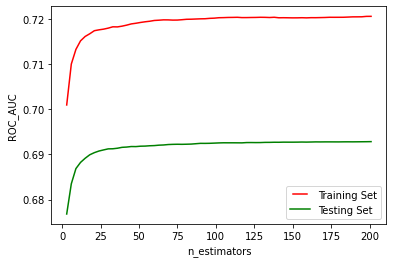

In [73]:
#Visualize AUC-ROC based on forest size.
line1, = plt.plot(actual, train_results_AUC, color="r", label="Training Set")
line2, = plt.plot(actual, test_results_AUC, color="g", label="Testing Set")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('ROC_AUC')
plt.xlabel('n_estimators')
plt.show()

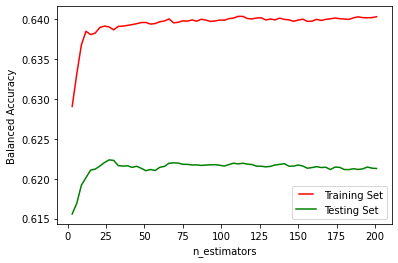

In [74]:
#Visualize balanced accuracy based on forest size.
line1, = plt.plot(actual, train_results_BalAcc, color="r", label="Training Set")
line2, = plt.plot(actual, test_results_BalAcc, color="g", label="Testing Set")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Balanced Accuracy')
plt.xlabel('n_estimators')
plt.show()

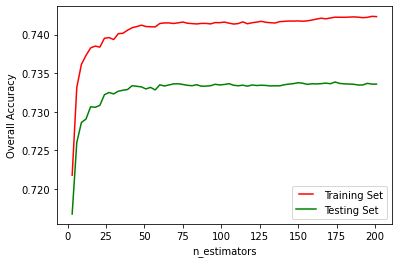

In [75]:
#Visualized overall accuracy based on forest size.
line1, = plt.plot(actual, train_results_OvrAcc, color="r", label="Training Set")
line2, = plt.plot(actual, test_results_OvrAcc, color="g", label="Testing Set")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Overall Accuracy')
plt.xlabel('n_estimators')
plt.show()

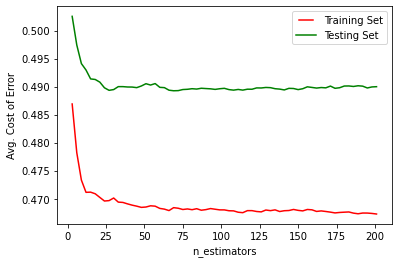

In [76]:
#Visualized error cost based on forest size.
line1, = plt.plot(actual, np.array(train_results_LoanLoss)/dfTrain.shape[0], color="r", label="Training Set")
line2, = plt.plot(actual, np.array(test_results_LoanLoss)/dfTest.shape[0], color="g", label="Testing Set")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Avg. Cost of Error')
plt.xlabel('n_estimators')
plt.show()

# FINAL FINAL RF

In [1375]:
#Random forest object used as the final model for predictions.
rfLearnFinal2 = RandomForestClassifier(n_estimators=75, max_features=0.5, n_jobs=-1, random_state=rs, 
                             verbose=3, max_samples=0.6, max_depth = 10)

In [595]:
#Random forest learner to be used as final model
rfLearnFinal = RandomForestClassifier(n_estimators=75, n_jobs=-1, random_state=rs,\
                                 verbose=2, max_depth=10, max_features=0.4,\
                                 max_samples = 0.2)

In [1376]:
#Setup pipeline.
stepsRF = [('under', RandomUnderSampler(sampling_strategy=0.7, random_state=rs)), ('model', rfLearnFinal2)]
pipelineRF = Pipeline(steps=stepsRF)

In [1377]:
#Train the model.
pipelineRF.fit(dfPostImpute[trainAll], trainLabels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 75building tree 2 of 75building tree 3 of 75

building tree 4 of 75

building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   20.2s


building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75
building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tr

[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.2min finished


Pipeline(steps=[('under',
                 RandomUnderSampler(random_state=0, sampling_strategy=0.7)),
                ('model',
                 RandomForestClassifier(max_depth=10, max_features=0.5,
                                        max_samples=0.6, n_estimators=75,
                                        n_jobs=-1, random_state=0,
                                        verbose=3))])

In [1378]:
#Get probability predictions
y_prob_RF = pipelineRF.predict_proba(dfPostImpute[testAll])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:    2.0s finished


In [1379]:
#Get label predictions
y_hat_RF = pipelineRF.predict(dfPostImpute[testAll])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:    2.1s finished


In [1380]:
#Scores based on default prob threshold.
getScores(testLabels, y_hat_RF, y_prob_RF[:,1])

,Accuracy,Precision(+),Recall(+),AUC,Error Cost
Result,0.734964,0.311934,0.453465,0.695715,233913


In [1381]:
#Confusion matrix
confusion_matrix(testLabels, y_hat_RF)

array([[240365,  62678],
       [ 34247,  28415]], dtype=int64)

In [1391]:
#Create Series object with the results
resultsRF = {'id': dfFinal[testAll].id.values, 'true_class': testLabels, 'predict_class_RF': y_hat_RF, 
                 'prob_RF':y_prob_RF[:,1]}

In [1392]:
#Convert the series to a dataframe
df_Results_RF = pd.DataFrame(resultsRF)

In [1393]:
#Preview the results dataframe.
df_Results_RF.head()

,id,true_class,predict_class_RF,prob_RF
0,73713571,0,0,0.376075
1,75051478,0,0,0.483233
2,75092979,0,0,0.410791
3,75123593,0,0,0.155637
5,75358919,0,0,0.409393


In [1394]:
#Save the results
df_Results_RF.to_csv('results_RF2.csv', index=False)

In [1384]:
#Get the random forest object from the pipeline object.
modelRF = pipelineRF[1]

In [1386]:
#Create dataframe with features and their importance as determined by the Random Forest model.
df_RF_Features = pd.DataFrame([dfPostImpute.columns,modelRF.feature_importances_]).T
df_RF_Features.columns = ['Feature', 'Importance']

In [1387]:
#Top 10 most important features in the random forest.
df_RF_Features.sort_values(by='Importance', ascending=False)[0:10]

,Feature,Importance
20,int_rate,0.297629
58,grade_A,0.131468
59,grade_B,0.0673115
1,annual_inc,0.0425632
5,dti,0.0423373
2,avg_cur_bal,0.0400542
0,acc_open_past_24mths,0.0377215
6,fico,0.0336661
8,installment,0.0305057
60,grade_C,0.0214035
